# Predict protein secondary structure with deep neural networks


**Author**: YOUR_NAME

**Due date**: March 30, 2025, 11:59 PM

This assignment is similar to the [previous one](https://dinglab.io/chem193/homework/2-protein-secondary-structure/script/main.html#) but uses deep neural networks instead of simple linear models. It also uses larger datasets. The training and test datasets are provided in the text files [train.txt](https://tufts.box.com/s/y4t82o03hhf92zw6dik0x9r7v09qdyhs) and [test.txt](https://tufts.box.com/s/v4ypbippcsnifjlkd7vrp478bb7ue92l), respectively. The format of the datasets is the same as in the previous assignment.
The task is to train a deep neural network model using the training dataset and predict the secondary structure of the proteins using their sequences in the test dataset.


In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx
from tqdm import tqdm
import optax
from sys import exit
import jax.random as jr
import matplotlib.pyplot as plt

## Input and output of the neural network model
Similary to the previous assignment, the model will predict the secondary structure of a protein using the sliding window approach. It predicts the secondary structure of a residue based on a window of residues centered at that residue. In the previous assignment, the window size was 15. In this assignment, the window size is a hyperparameter that you can choose. The default value is 31, but you can change it to any odd number.

Assume that the window size is `k`. The input to the neural network model is a 1d array of `k` integers, each representing the index of that residue in the amino acid alphabet, `ACDEFGHIKLMNPQRSTVWY*`. For example, if `k = 5`, the sequence `ACACG` will be represented as `[0, 1, 0, 1, 5]`. The output of the model is a 1d array of 3 floats, each representing the logorihtm of the probability of the corresponding secondary structure, `helix`, `strand`, and `other`. For example, the output `[-1.0986123, -1.0986123, -1.0986123]` represents the probabilities `[0.333, 0.333, 0.333]` for the secondary structures `helix`, `strand`, and `other`, respectively.

### Process the training data
Given the design of the model, the data in `train.txt` are not directly suitable for training. The data need to be processed to create the input and output pairs for the model. For each sequence in the training data, we extract all windows of size `k` and convert both the amino acid sequence and the secondary structure to the integer representation. The following two code cells show how it is done.

In [3]:
## you need to change `path_to_train` to the path of the train.txt file
path_to_train = "../data/train.txt"

## read data from train.txt
train_data = {}

## train_seq is a dictionary with the following structure:
## train_seq[protein_name] = (sequence, secondary_structure),
## where protein_name is the name of the protein, sequence is the amino acid sequence of the protein, and secondary_structure is the secondary structure of the protein as given in the train.txt file


with open(path_to_train, "r") as f:
    for line in f:
        if line.startswith(">"):
            name = line.strip()[1:]
            train_data[name] = []
        else:
            train_data[name].append(line.strip())


## here we split the data into training and validation data
## we use 80% of the data for training and 20% for validation

names = list(train_data.keys())
names_validation = np.random.choice(names, int(len(names)*0.2), replace=False)

valid_data = {name: train_data[name] for name in names_validation}
for name in names_validation:
    train_data.pop(name)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(valid_data)}")


Number of training samples: 34331
Number of validation samples: 8582


In [4]:
def get_windows_per_seq(seq, secondary_structure, window_size=31):
    """ Get windows for a single sequence

    Args:
        seq (str): amino acid sequence
        secondary_structure (str): secondary structure
        window_size (int): window size

    Returns:
        xs (np.array): input windows
        ys (np.array): output windows

    """
    ## amino acid order
    amino_acids = "ACDEFGHIKLMNPQRSTVWY*"

    seq = [amino_acids.index(s) for s in seq]
    for _ in range(window_size // 2):
        seq = [amino_acids.index("*")] + seq + [amino_acids.index("*")]

    windows = []
    for i in range(window_size//2, len(seq) - window_size//2):
        x = np.array(seq[i - window_size//2 : i + window_size//2 + 1], dtype=np.int8)
        y = int(secondary_structure[i - window_size//2])

        windows.append((x, y))

    xs = np.array([x for x, _ in windows], dtype=np.int8)
    ys = np.array([y for _, y in windows], dtype=np.int8)

    return xs, ys


def get_windows(data, window_size=31):
    """ Get windows for a dataset"
    
    Args:
        data (dict): dataset
        window_size (int): window size

    Returns:
        xs (np.array): input windows
        ys (np.array): output windows
    """

    xs = []
    ys = []
    for name in tqdm(data.keys()):
        seq, ss = data[name]
        x, y = get_windows_per_seq(seq, ss, window_size=window_size)
        xs.append(x)
        ys.append(y)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs, ys


In [5]:
## the default window size is 31 amino acids (15 on each side of the central amino acid)
## you can change the window size by changing the value of the window_size variable
window_size = 31

## get windows for training and validation data
train_xs, train_ys = get_windows(train_data, window_size)
valid_xs, valid_ys = get_windows(valid_data, window_size)

100%|██████████| 8582/8582 [00:11<00:00, 722.15it/s]


## The neural network model
You need to implement a deep neural network model using the `equinox` library. The input and output of the model are described above.

In [8]:
############################################################################################################  write your code for the following NeuralNetwork class (50 points)
####################################################################################################
class NeuralNetwork(eqx.Module):
    emb: eqx.nn.Embedding
    emb_layer: list
    res_layer_1: list
    res_layer_2: list
    res_layer_3: list
    output_layer: list

    def __init__(self, key):
        subkey, key = jr.split(key)
        self.emb = eqx.nn.Embedding(num_embeddings=21, embedding_size=16, key=subkey)
        emb_size = 16*window_size
        res_size = 32

        subkey, key = jr.split(key)
        self.emb_layer = [
            eqx.nn.Linear(emb_size, res_size, key=subkey),
            jax.nn.relu,
        ]

        subkey1, subkey2, key = jr.split(key, 3)
        self.res_layer_1 = [
            eqx.nn.Linear(res_size, 64, key=subkey1),
            jax.nn.relu,
            eqx.nn.Linear(64, res_size, key=subkey2),
            jax.nn.relu,
        ]

        subkey1, subkey2, key = jr.split(key, 3)
        self.res_layer_2 = [
            eqx.nn.Linear(res_size, 64, key=subkey1),
            jax.nn.relu,
            eqx.nn.Linear(64, res_size, key=subkey2),
            jax.nn.relu,
        ]

        subkey1, subkey2, key = jr.split(key, 3)
        self.res_layer_3 = [
            eqx.nn.Linear(res_size, 64, key=subkey1),
            jax.nn.relu,
            eqx.nn.Linear(64, res_size, key=subkey2),
            jax.nn.relu,
        ]

        subkey1, subkey2, key = jr.split(key, 3)
        self.output_layer = [
            eqx.nn.Linear(res_size, 3, key=subkey1),
            jax.nn.log_softmax,
        ]


    def __call__(self, x):
        """ Forward pass

        Args:
            x (jnp.array): 1D array of integers representing amino acids in a window
        
        Returns:
            logp (jnp.array): 1D array of 3 floats representing log-probabilities of secondary structure classes
        """

        x = jax.vmap(self.emb)(x)
        x = x.flatten()

        for layer in self.emb_layer:
            x = layer(x)

        x_ini = x
        for layer in self.res_layer_1:
            x = layer(x)
        x = x + x_ini

        x_ini = x
        for layer in self.res_layer_2:
            x = layer(x)
        x = x + x_ini

        x_ini = x
        for layer in self.res_layer_3:
            x = layer(x)
        x = x + x_ini
        
        for layer in self.output_layer:
            x = layer(x)

        return x


## Training the model
To train the model, you need to finish the implementation of the `loss_fn` function. The function takes the model, a batch of input and output pairs, and returns the loss. The loss should be the same as the loss function used in the previous assignment. To monitor the training process, you also need to implement the three functions: `make_predictions`, and `compute_accuracy`.

In [9]:
## Note that you could comment the @eqx.filter_jit decorator during the development of the loss function so that the error messages are more informative. Once the loss function is working, you can uncomment the decorator to speed up the training process. The same applies to the make_predictions function

@eqx.filter_jit
def loss_fn(model, xs, ys):
    """ Loss function for a batch of windows

    Args:
        model (NeuralNetwork): neural network model
        xs (jnp.array): 2D array of integers representing amino acids in windows. Shape:(batch_size, window_size)
        ys (jnp.array): 1D array of integers representing secondary structure classes. Shape: (batch_size,)
    
    Returns:
        loss (jnp.array): the average loss over the batch
    """

    ##############################################################################################
    #### write your code loss function (15 points)
    ###############################################################################################
    log_prob = jax.vmap(model)(xs)
    loss = -jnp.mean(jnp.sum(log_prob * jax.nn.one_hot(ys, 3), axis=1))
    return loss



@eqx.filter_jit
def make_predictions(model, xs):
    """ Make predictions for a batch of windows"
    
    Args:
        model (NeuralNetwork): neural network model
        xs (jnp.array): 2D array of integers representing amino acids in windows. Shape:(batch_size, window_size)

    Returns:
        predictions (jnp.array): 1D array of integers representing predicted secondary structure classes. Shape: (batch_size,)

    """


    ################################################
    #### write your code loss function (15 points)
    ################################################


    log_prob = jax.vmap(model)(xs)
    predictions = jnp.argmax(log_prob, axis=1)
    return predictions


def compute_average_loss(model, xs, ys, batch_size=1024*16):
    """ Compute average loss for a dataset of windows by batching

    Args:
        model (NeuralNetwork): neural network model
        xs (jnp.array): 2D array of integers representing amino acids in windows. Shape:(num_samples, window_size)
        ys (jnp.array): 1D array of integers representing secondary structure classes. Shape: (num_samples,)
        batch_size (int): batch size

    Returns:
        loss (float): average loss over the dataset
    
    """
    total_loss = 0
    num_batches = len(xs) // batch_size + 1
    for idx_batch in range(num_batches):
        start_idx = idx_batch * batch_size
        end_idx = start_idx + batch_size
        batch_xs = xs[start_idx:end_idx]
        batch_ys = ys[start_idx:end_idx]

        loss = loss_fn(model, batch_xs, batch_ys)
        total_loss += loss * batch_xs.shape[0]
    loss = total_loss / len(xs)
    return loss


def compute_accuracy(model, xs, ys, batch_size=1024*16):
    """ Compute accuracy for a dataset of windows by batching"
    
    Args:
        model (NeuralNetwork): neural network model
        xs (jnp.array): 2D array of integers representing amino acids in windows. Shape:(num_samples, window_size)
        ys (jnp.array): 1D array of integers representing secondary structure classes. Shape: (num_samples,)
        batch_size (int): batch size

    Returns:
        accuracy (float): accuracy over the dataset
    """


    #####################################################
    ####  write your code loss function (10 points)  ####
    #####################################################


    num_batches = len(xs) // batch_size + 1
    total = 0
    correct = 0
    for idx_batch in range(num_batches):
        start_idx = idx_batch * batch_size
        end_idx = start_idx + batch_size
        batch_xs = xs[start_idx:end_idx]
        batch_ys = ys[start_idx:end_idx]
        predictions = make_predictions(model, batch_xs)
        correct += jnp.sum(predictions == batch_ys)
        total += len(batch_ys)

    return correct / total




### Train the model using stochastic gradient descent (SGD) with the Adam optimizer

In [10]:
## initialize the model 
key = jr.PRNGKey(0)
model = NeuralNetwork(key)


## initialize the optimizer
## the learning rate is set to 0.001
optim = optax.adamw(0.001)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

## training loop
## Note that you could comment the @eqx.filter_jit decorator during the development so that the error messages are more informative. Once you are done, you can uncomment the decorator to speed up the training process
@eqx.filter_jit
def make_step(model, batch_xs, batch_ys, opt_state):
    """ Make a single optimization step using a batch of windows

    Args:
        model (NeuralNetwork): neural network model
        batch_xs (jnp.array): 2D array of integers representing amino acids in windows. Shape:(batch_size, window_size)
        batch_ys (jnp.array): 1D array of integers representing secondary structure classes. Shape: (batch_size,)
        opt_state (optax.OptState): optimizer state

    Returns:
        model (NeuralNetwork): updated neural network model
        opt_state (optax.OptState): updated optimizer state
        loss_value (float): loss value for the batch    
    """

    loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, batch_xs, batch_ys)
    updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(model, eqx.is_array)
    )    
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

The following code cell shows how to train the model using the Adam optimizer. We monitor the training process by computing the loss and accuracy on the training and validation datasets after each epoch. 

In [11]:
## set the number of epochs and batch size
## you can change both as needed
num_epochs = 50
batch_size = 1024 * 16

train_loss_record = []
valid_loss_record = []
train_accuracy_record = []
valid_accuracy_record = []


for epoch in range(num_epochs):
    idx = np.arange(len(train_xs))
    np.random.shuffle(idx)
    train_xs = train_xs[idx]
    train_ys = train_ys[idx]

    num_batches = len(train_xs) // batch_size
    for idx_batch in range(num_batches):
        start_idx = idx_batch * batch_size
        end_idx = start_idx + batch_size
        batch_xs = train_xs[start_idx:end_idx]
        batch_ys = train_ys[start_idx:end_idx]

        model, opt_state, loss_value = make_step(model, batch_xs, batch_ys, opt_state)

        if idx_batch % 10 == 0:
            print(f"epoch {epoch:5>d}, batch {idx_batch:5>d}, train_loss {loss_value:5.3f}")

    
    train_loss = compute_average_loss(model, train_xs, train_ys)
    train_accuracy = compute_accuracy(model, train_xs, train_ys)

    valid_loss = compute_average_loss(model, valid_xs, valid_ys)
    valid_accuracy = compute_accuracy(model, valid_xs, valid_ys)
    
    print(f"epoch {epoch:>5d}, train_loss {train_loss:5.3f}, valid_loss {valid_loss:5.3f}, train_accuracy {train_accuracy:7.2%}, valid_accuracy {valid_accuracy:7.2%}")

    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_accuracy_record.append(train_accuracy)
    valid_accuracy_record.append(valid_accuracy)

epoch 0, batch 0, train_loss 1.090
epoch 0, batch 10, train_loss 1.006
epoch 0, batch 20, train_loss 0.951
epoch 0, batch 30, train_loss 0.926
epoch 0, batch 40, train_loss 0.902
epoch 0, batch 50, train_loss 0.890
epoch 0, batch 60, train_loss 0.868
epoch 0, batch 70, train_loss 0.865
epoch 0, batch 80, train_loss 0.854
epoch 0, batch 90, train_loss 0.852
epoch 0, batch 100, train_loss 0.849
epoch 0, batch 110, train_loss 0.842
epoch 0, batch 120, train_loss 0.836
epoch 0, batch 130, train_loss 0.841
epoch 0, batch 140, train_loss 0.831
epoch 0, batch 150, train_loss 0.825
epoch 0, batch 160, train_loss 0.817
epoch 0, batch 170, train_loss 0.813
epoch 0, batch 180, train_loss 0.805
epoch 0, batch 190, train_loss 0.804
epoch 0, batch 200, train_loss 0.809
epoch 0, batch 210, train_loss 0.797
epoch 0, batch 220, train_loss 0.789
epoch 0, batch 230, train_loss 0.786
epoch 0, batch 240, train_loss 0.776
epoch 0, batch 250, train_loss 0.773
epoch 0, batch 260, train_loss 0.774
epoch 0, bat

### Plot the loss and accuracy curves during training
To visualize the training process, we plot the loss and accuracy curves during training.

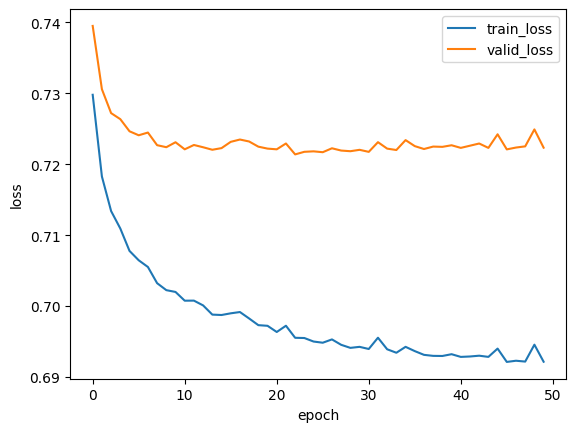

In [12]:
fig = plt.figure()
plt.clf()
plt.plot(train_loss_record, label="train_loss")
plt.plot(valid_loss_record, label="valid_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

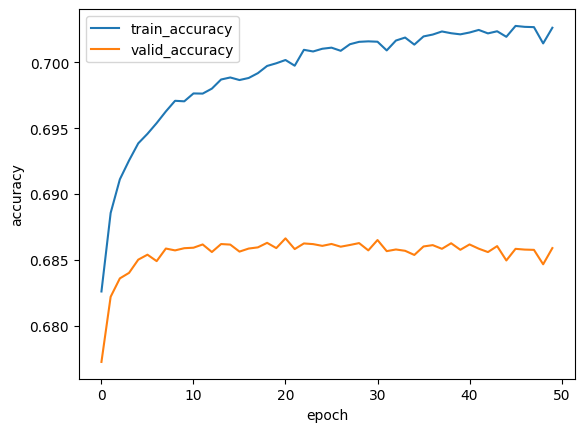

In [13]:
fig = plt.figure()
plt.clf()
plt.plot(train_accuracy_record, label="train_accuracy")
plt.plot(valid_accuracy_record, label="valid_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

**Based on the loss and accuracy curves, answer the following question**:

As the number of epochs increases, what happens to the loss and accuracy on the training and validation datasets? Why the behavior of the loss/accuracy curves is different on the training and validation datasets?

_Your answer to the above question_

### Save the model with the highest validation accuracy
To avoid overfitting, we save the model with the highest validation accuracy after each epoch.

In [14]:
## re-initialize the model 
key = jr.PRNGKey(100)
model = NeuralNetwork(key)


## initialize the optimizer
## the learning rate is set to 0.001
optim = optax.adamw(0.001)
opt_state = optim.init(eqx.filter(model, eqx.is_array))


## you can change the number of epochs and batch size as needed
num_epochs = 50
batch_size = 1024 * 16

highest_valid_accuracy = 0
best_model = None

for epoch in range(num_epochs):
    idx = np.arange(len(train_xs))
    np.random.shuffle(idx)
    train_xs = train_xs[idx]
    train_ys = train_ys[idx]

    num_batches = len(train_xs) // batch_size
    for idx_batch in range(num_batches):
        start_idx = idx_batch * batch_size
        end_idx = start_idx + batch_size
        batch_xs = train_xs[start_idx:end_idx]
        batch_ys = train_ys[start_idx:end_idx]

        model, opt_state, loss_value = make_step(model, batch_xs, batch_ys, opt_state)

        if idx_batch % 10 == 0:
            print(f"epoch {epoch:5>d}, batch {idx_batch:5>d}, train_loss {loss_value:5.3f}")

    
    train_loss = compute_average_loss(model, train_xs, train_ys)
    train_accuracy = compute_accuracy(model, train_xs, train_ys)

    valid_loss = compute_average_loss(model, valid_xs, valid_ys)
    valid_accuracy = compute_accuracy(model, valid_xs, valid_ys)
    
    print(f"epoch {epoch:5>d}, train_loss {train_loss:5.3f}, valid_loss {valid_loss:5.3f}, train_accuracy {train_accuracy:7.2%}, valid_accuracy {valid_accuracy:7.2%}")

    if valid_accuracy > highest_valid_accuracy:
        highest_valid_accuracy = valid_accuracy        
        eqx.tree_serialise_leaves("../output/model-with-highest-valid-accuracy.eqx", model)
        print(f"model saved with highest valid accuracy: {highest_valid_accuracy:7.2%}")

epoch 0, batch 0, train_loss 1.128
epoch 0, batch 10, train_loss 1.036
epoch 0, batch 20, train_loss 0.986
epoch 0, batch 30, train_loss 0.954
epoch 0, batch 40, train_loss 0.925
epoch 0, batch 50, train_loss 0.906
epoch 0, batch 60, train_loss 0.895
epoch 0, batch 70, train_loss 0.877
epoch 0, batch 80, train_loss 0.861
epoch 0, batch 90, train_loss 0.858
epoch 0, batch 100, train_loss 0.850
epoch 0, batch 110, train_loss 0.841
epoch 0, batch 120, train_loss 0.828
epoch 0, batch 130, train_loss 0.839
epoch 0, batch 140, train_loss 0.836
epoch 0, batch 150, train_loss 0.825
epoch 0, batch 160, train_loss 0.819
epoch 0, batch 170, train_loss 0.822
epoch 0, batch 180, train_loss 0.821
epoch 0, batch 190, train_loss 0.812
epoch 0, batch 200, train_loss 0.807
epoch 0, batch 210, train_loss 0.809
epoch 0, batch 220, train_loss 0.808
epoch 0, batch 230, train_loss 0.803
epoch 0, batch 240, train_loss 0.793
epoch 0, batch 250, train_loss 0.783
epoch 0, batch 260, train_loss 0.793
epoch 0, bat

## Make predictions on the test data
After the model is trained, you make predictions on the test sequences using saved model that has the highest validation accuracy. The test sequences are provided in the file `test.txt`. You need to use the trained model to predict the secondary structure of all residues in the test sequences. The predictions should be written to a text file named `predictions.txt` and its format should be the same as the file `train.txt`.

In [40]:
## load the model with the highest validation accuracy
key = jr.PRNGKey(100)
model = NeuralNetwork(key)
model = eqx.tree_deserialise_leaves("../output/model-with-highest-valid-accuracy.eqx", model)

###########################################################################
#### write your code here for the task described above (10 points) ########
###########################################################################




## Submission instructions
1. You need to create a folder named `assignment-3-protein-secondary-structure-nn` under the OneDrive folder that has been shared with you.
2. Complete the code and answer the questions as described above in this Jupyter notebook. Make sure to save your work and name your Jupyter notebook as `main.ipynb`.
3. Upload the `main.ipynb`, `pyproject.toml`, and `test_prediction.txt` files to the `assignment-3-protein-secondary-structure-nn` folder that you created in step 1.

**Note:** Please make sure the names of the folder and files are exactly as instructed.